## Fraud Consumer metric


In [1]:
import pandas as pd
import numpy as np
import os
import re

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

22/10/09 03:44:39 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.21.131.106 instead (on interface eth0)
22/10/09 03:44:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 03:44:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/09 03:44:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.8.10 (default, Jun 22 2022 20:18:18)
Spark context Web UI available at http://172.21.131.106:4041
Spark context available as 'sc' (master = local[*], app id = local-1665247481435).
SparkSession available as 'spark'.
22/10/09 03:44:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Regression

In [2]:
consumer_fraud_sdf = spark.read.parquet("../data/temp/consumer_fraud")
transaction_sdf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_sdf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_sdf3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_sdf1.union(transaction_sdf2).union(transaction_sdf3)

In [3]:
transaction_sdf1.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



### plot on transaction 1

In [4]:
from pyspark.sql import functions as F

consumer_agg_daily_sdf1 = transaction_sdf1.groupBy(["user_id","order_datetime"]).agg(
    F.sum(F.col('dollar_value')).alias('tot_dollar_value'),
    F.countDistinct(F.col('order_id')).alias("total_order")
)

consumer_fraud_join_df1 = consumer_agg_daily_sdf1.join(consumer_fraud_sdf,on=["user_id","order_datetime"]).toPandas()

Text(0.5, 1.0, 'tot_dollar_value vs fraud_probability')

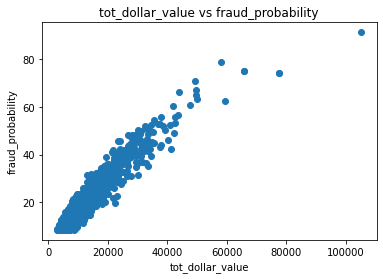

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=consumer_fraud_join_df1["tot_dollar_value"],y=consumer_fraud_join_df1["fraud_probability"])
plt.xlabel('tot_dollar_value')
plt.ylabel('fraud_probability') 
plt.title('tot_dollar_value vs fraud_probability')


Text(0.5, 1.0, 'total_order vs fraud_probability')

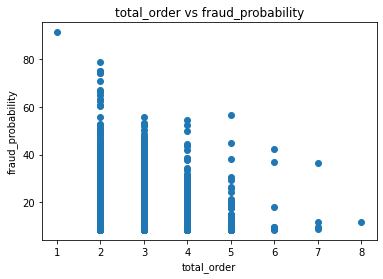

In [6]:
plt.scatter(x=consumer_fraud_join_df1["total_order"],y=consumer_fraud_join_df1["fraud_probability"])
plt.xlabel('total_order')
plt.ylabel('fraud_probability') 
plt.title('total_order vs fraud_probability')

### plot on transaction 2

In [7]:
consumer_agg_daily_sdf2 = transaction_sdf2.groupBy(["user_id","order_datetime"]).agg(
    F.sum(F.col('dollar_value')).alias('tot_dollar_value'),
    F.countDistinct(F.col('order_id')).alias("total_order")
)

consumer_fraud_join_df2 = consumer_agg_daily_sdf2.join(consumer_fraud_sdf,on=["user_id","order_datetime"]).toPandas()

Text(0.5, 1.0, 'tot_dollar_value vs fraud_probability')

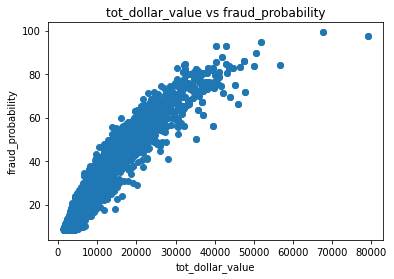

In [8]:
plt.scatter(x=consumer_fraud_join_df2["tot_dollar_value"],y=consumer_fraud_join_df2["fraud_probability"])
plt.xlabel('tot_dollar_value')
plt.ylabel('fraud_probability') 
plt.title('tot_dollar_value vs fraud_probability')

Text(0.5, 1.0, 'total_order vs fraud_probability')

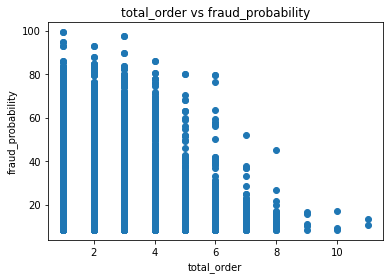

In [9]:
plt.scatter(x=consumer_fraud_join_df2["total_order"],y=consumer_fraud_join_df2["fraud_probability"])
plt.xlabel('total_order')
plt.ylabel('fraud_probability') 
plt.title('total_order vs fraud_probability')

## check distribution of normal transaction

In [10]:
consumer_agg_daily_df1 = consumer_agg_daily_sdf1.toPandas()

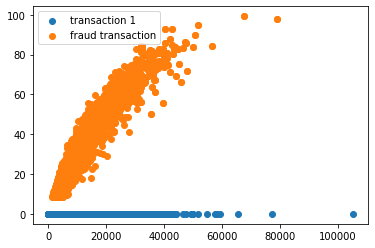

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=consumer_agg_daily_df1['tot_dollar_value'], y=[0]*consumer_agg_daily_df1['tot_dollar_value'].count(),label="transaction 1")
ax1.scatter(x=consumer_fraud_join_df2["tot_dollar_value"],y=consumer_fraud_join_df2["fraud_probability"],label="fraud transaction")
plt.legend(loc='upper left')
plt.show()

# plt.scatter(x=consumer_agg_daily_df1['tot_dollar_value'], y=[np.mean(consumer_agg_daily_df1['tot_dollar_value'])]*consumer_agg_daily_df1['tot_dollar_value'].count())

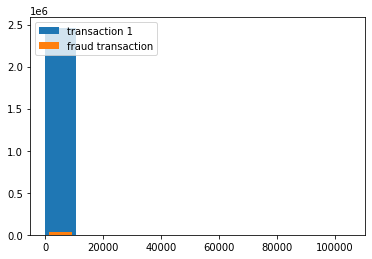

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.hist(x=consumer_agg_daily_df1['tot_dollar_value'],label="transaction 1")
ax1.hist(x=consumer_fraud_join_df2["tot_dollar_value"],label="fraud transaction")
plt.legend(loc='upper left')
plt.show()

# Regression on fraud probability

In [13]:
from statsmodels.formula.api import ols, glm
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

consumer_fraud_join_df_1_2 = consumer_fraud_join_df1.append(consumer_fraud_join_df2, ignore_index=True)

fit = ols(
    formula="fraud_probability ~ tot_dollar_value + total_order + tot_dollar_value/total_order",
    data=consumer_fraud_join_df_1_2
).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:      fraud_probability   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 5.208e+04
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        03:45:24   Log-Likelihood:                -99899.
No. Observations:               34864   AIC:                         1.998e+05
Df Residuals:                   34860   BIC:                         1.998e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/tmp/ipykernel_509/3275048092.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  consumer_fraud_join_df_1_2 = consumer_fraud_join_df1.append(consumer_fraud_join_df2, ignore_index=True)


total_order is no longer significant, but the interaction term is.
the interaction term explains why the scatter plot has a log like shape. 
When total amount is the same, less avg dollar value meaning less fraud prob

### Formula: fraud_probability ~ tot_dollar_value + tot_dollar_value/total_order

## Train model with pyspark model
 consider scalability we will use pyspark module instead


edit: use logistic regression with identity link instead , because our response is 0-1, and the g(response) = response follows a linear trend with our predictors

In [14]:
consumer_agg_daily_train = spark.createDataFrame(consumer_fraud_join_df_1_2) \
    .withColumn(
        "avg_dollar_value",
        F.col("tot_dollar_value")/F.col("total_order") # interaction feature added
    )

In [15]:
from pyspark.ml.regression import LinearRegression
# from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import Interaction
# consumer_regression = consumer_agg_daily_all[[]].apply(lambda row:join_prob_p_val(row[0],row[1],row[2],row[3],row[4],row[5]),axis=1)
features = 'fraud_features'
input_cols = ['tot_dollar_value','avg_dollar_value'] 
# assembler = Interaction()
# assembler.setInputCols(["tot_dollar_value", "total_order"])
# assembler.setOutputCol("interaction")
assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

model_sdf = assembler.transform(consumer_agg_daily_train.dropna('any'))
# Display the features and targets for our model
model_sdf.select(features).head(5), model_sdf.select('fraud_probability').head(5)



IllegalArgumentException: avg_dollar_value_per_order does not exist. Available: user_id, order_datetime, tot_dollar_value, total_order, fraud_probability, avg_dollar_value

In [ ]:
lm = LinearRegression(
    featuresCol=features, 
    labelCol='fraud_probability',
    maxIter=1000
).fit(model_sdf)

# glm = GeneralizedLinearRegression(
#     family="binomial", 
#     link="identity",
#     predictionCol='prediction',
#     labelCol='fraud_probability',
# ).fit(model_sdf)


In [ ]:
# print(lm.coefficients)
# print(lm.intercept)
# coefficient is different, investigate

In [ ]:
# save model

model_path = "../models" + "/fraud_regression"
lm.write().overwrite().save(model_path)


## apply the pyspark model to all data

In [ ]:
consumer_agg_daily_all = transaction.groupBy(["user_id","order_datetime"]).agg(
    F.sum(F.col('dollar_value')).alias('tot_dollar_value'),
    F.countDistinct(F.col('order_id')).alias("total_order")
).withColumn(
    "avg_dollar_value",
    F.col("tot_dollar_value")/F.col("total_order") # interaction feature added
)
#consumer_agg_daily_all.count() # 9 mil data


In [ ]:
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler
model_path = "../models" + "/fraud_regression"
lm = LinearRegressionModel.load(model_path)
features = 'fraud_features'
input_cols = ['tot_dollar_value','avg_dollar_value'] 
# assembler = Interaction()
# assembler.setInputCols(["tot_dollar_value", "total_order"])
# assembler.setOutputCol("interaction")
assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

predict_sdf = assembler.transform(consumer_agg_daily_all)
result_sdf = lm.transform(predict_sdf)


In [ ]:
result_sdf.show(5)

In [ ]:
from pyspark.sql.types import StructType, StructField, LongType

def with_column_index(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField("ColumnIndex", LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

df1_ci = with_column_index(consumer_agg_daily_all)
df2_ci = with_column_index(result_sdf)


user_datetime_predict_sdf = df1_ci.join(df2_ci, df1_ci.ColumnIndex == df2_ci.ColumnIndex, 'inner').drop("ColumnIndex")


#user_datetime_predict_sdf = consumer_agg_daily_all.join(result_sdf.select(["prediction","columnindex"]),on="columnindex")
user_datetime_predict_sdf= user_datetime_predict_sdf.withColumnRenamed(
    "prediction",
    "fraud_prob"
)

## 

## calculate the discounted revenue

In [ ]:
from pyspark.sql.functions import udf, array
from pyspark.sql.types import FloatType
THRESHHOLD = lm.intercept

def calculate_discounted_revenue(rate):
    if rate < THRESHHOLD:
        return 1
    elif rate > 100:
        return 0
    else: 
        return 1-(rate*0.01)
       
# sdf = sdf.withColumn(
#     'transformed_col',
#     some_udf(F.col('raw_col'))
# )
convert_rate = udf(lambda z: calculate_discounted_revenue(z),FloatType())

In [ ]:
# run slice by slice
transaction_slices = [transaction_sdf1,transaction_sdf2,transaction_sdf3]

for i in range(3):
    merchant_user_agg_sdf = transaction_slices[i].groupBy(["merchant_abn","order_datetime","user_id"]).agg(
        F.countDistinct(F.col("order_id")).alias("no_order"),
        F.sum(F.col("dollar_value")).alias("dollar_amount")
    )



    user_discounted_spending_sdf = merchant_user_agg_sdf \
        .join(user_datetime_predict_sdf.select(["user_id","order_datetime","fraud_prob"]),on=["user_id","order_datetime"]) \
        .withColumn(
            "convert_rate",
            convert_rate(F.col("fraud_prob"))
        ).withColumn(
            "discounted_spending",
            F.col("convert_rate") * F.col("dollar_amount")
        )

    merchant_discounted_daily_revenue = user_discounted_spending_sdf.groupBy(["merchant_abn","order_datetime"]).agg(
        F.sum(F.col("discounted_spending")).alias("discounted_daily_revenue")
    )

    merchant_discounted_daily_revenue.write.mode('overwrite').parquet(f'../data/curated/merchant_discounted_daily_revenue_slice_{i}.parquet')


### debug (dont need to put into the script)

In [ ]:
test = merchant_discounted_daily_revenue.where(
    F.col("discounted_daily_revenue")<0
)
############
# merchant_user_agg_sdf =transaction_sdf1.groupBy(["merchant_abn","order_datetime","user_id"]).agg(
#     F.countDistinct(F.col("order_id")).alias("no_order"),
#     F.sum(F.col("dollar_value")).alias("dollar_amount")
# )



# test = merchant_user_agg_sdf \
#     .join(user_datetime_predict_sdf.select(["user_id","order_datetime","fraud_prob"]),on=["user_id","order_datetime"]) \
#     .withColumn(
#         "convert_rate",
#         convert_rate(F.col("fraud_prob"))
#     )

# test_filter = test.where(
#     F.col("convert_rate") < 0
# )

In [ ]:
test.count()

In [ ]:
user_discounted_spending_sdf.head(5)

In [ ]:
#test_filter.count() # 0

In [ ]:
#user_datetime_predict_sdf.head()
user_discounted_spending_sdf = merchant_user_agg_sdf \
        .join(user_datetime_predict_sdf.select(["user_id","order_datetime","fraud_prob"]),on=["user_id","order_datetime"]) \
        .withColumn(
            "convert_rate",
            convert_rate(F.col("fraud_prob"))
        )

In [ ]:
test = user_discounted_spending_sdf.where(
    F.col("convert_rate") < 0
)

In [ ]:
test.head()

In [ ]:
merchant_discounted_daily_revenue = user_discounted_spending_sdf.groupBy(["merchant_abn","order_datetime"]).agg(
    F.sum(F.col("discounted_spending")).alias("discounted_daily_revenue")
)

In [ ]:
merchant_discounted_daily_revenue.printSchema()

In [ ]:
merchant_discounted_daily_revenue.head()

In [ ]:
#merchant_discounted_daily_revenue.head() # cant run

In [ ]:
# from pyspark.sql import functions as F
# slice0 = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_0.parquet")
# slice1 = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_1.parquet")
# slice3 = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_2.parquet")

# combine_slices = slice0.union(slice1).union(slice3)

# test = combine_slices.where(
#     F.col("discounted_daily_revenue") < 0
# ).count()

# test

### Remove Fraud data from the transaction set(don't put it into script)
since fraud data is only a small subset of the data, consider remove all transaction entries with fraud probability


In [ ]:
# convert merchant fraud, consumer fraud to spark df
merchant_fraud_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud_df.to_parquet("../data/temp/merchant_fraud")
merchant_fraud_sdf = spark.read.parquet("../data/temp/merchant_fraud")

consumer_fraud_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud_df.to_parquet("../data/temp/consumer_fraud")
consumer_fraud_sdf = spark.read.parquet("../data/temp/consumer_fraud")

In [ ]:
# save all transaction data to a spark dataframe: transaction
transaction_sdf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_sdf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_sdf3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_sdf1.union(transaction_sdf2).union(transaction_sdf3)

In [ ]:
# find all transaction on merchant fraud day
merchant_fraud_sdf = spark.read.parquet("../data/temp/merchant_fraud")
merchant_transaction_on_fraud_day = transaction.join(merchant_fraud_sdf.select(["merchant_abn","order_datetime"]), on=["merchant_abn","order_datetime"])

In [ ]:
transaction.printSchema()

In [ ]:
merchant_transaction_on_fraud_day.printSchema()

In [ ]:
# find all transaction on consumer fraud day
consumer_fraud_sdf = spark.read.parquet("../data/temp/consumer_fraud")
consumer_transaction_on_fraud_day = transaction.join(consumer_fraud_sdf.select(["user_id","order_datetime"]), on=["user_id","order_datetime"])

In [ ]:
# filter fraud transactions

order = ["user_id","merchant_abn","dollar_value","order_id","order_datetime"]
transaction_fraud_rm = transaction.subtract(merchant_transaction_on_fraud_day.select(order)).subtract(consumer_transaction_on_fraud_day.select(order))

transaction_fraud_rm can be used for further analysis

### Derive fraud rate and other features

#### Definition:

Merchant Fraud rate: weighted fraud orders / total orders
Fraud 
